
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

554

In [6]:
df.shape

(24573, 80)

In [7]:
df = df[df["FPL_pos"].isin(["GK"])]

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [8]:
rolling_gameweeks = [2, 4]
# rolling_gameweeks = [5]

to_predict = ["FPL_points"]
standard_features = [
             "Was_home", # Home/Away
             # "Team_rating", "Opp_rating", "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                # 'Gls', 'Sh', 'SoT', # Goals
                # 'Ast', # Assists
                # 'CrdY', 'CrdR', # Cards
                # "xG", 
                # 'xA', # Expected
                'Player_CS', # Defence
                # 'Team_score', 
                'Opp_score', 'Team_result', # Team form
                "Saves",
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'Influence', 'Creativity', 'Threat', 
                # 'ICT_index', # ICT
                "FPL_points", 
                # "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos"]

# Feature engineering

In [9]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [10]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [11]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [12]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [13]:
df = label_encoding(df, "Start")

In [14]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [15]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [16]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [17]:
# dropping NaNs
df = df.dropna(axis=0)

In [18]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [19]:
df.columns

Index(['FPL_points', 'FPL_points_2', 'FPL_points_4', 'FPL_pos', 'GW', 'Min_2',
       'Min_4', 'Name_original', 'Opp_rating', 'Opp_score_2', 'Opp_score_4',
       'Opponent', 'Player_CS_2', 'Player_CS_4', 'Saves_2', 'Saves_4',
       'Season', 'Start_2', 'Start_4', 'Team', 'Team_rating', 'Team_result_2',
       'Team_result_4', 'Was_home'],
      dtype='object')

In [20]:
df.shape

(2040, 24)

In [21]:
# saving to file
df.to_csv("data/df_features_gk.csv", index=False)

In [49]:
features

['Was_home',
 'Min_2',
 'Start_2',
 'Player_CS_2',
 'Opp_score_2',
 'Team_result_2',
 'Saves_2',
 'FPL_points_2',
 'Min_4',
 'Start_4',
 'Player_CS_4',
 'Opp_score_4',
 'Team_result_4',
 'Saves_4',
 'FPL_points_4']

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [22]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [23]:
# training data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [24]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [25]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [26]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((1771, 15), (34, 15), (269, 15))

# Model

In [27]:
model = GradientBoostingRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor(random_state=42)

In [28]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 125 ms
Wall time: 163 ms


GradientBoostingRegressor(random_state=42)

# Getting predictions

In [29]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [30]:
X_test.shape

(34, 15)

In [31]:
preds, predictions = get_predictions(model, df, X_test)

In [32]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [33]:
df.columns

Index(['FPL_points', 'FPL_points_2', 'FPL_points_4', 'FPL_pos', 'GW', 'Min_2',
       'Min_4', 'Name_original', 'Opp_rating', 'Opp_score_2', 'Opp_score_4',
       'Opponent', 'Player_CS_2', 'Player_CS_4', 'Saves_2', 'Saves_4',
       'Season', 'Start_2', 'Start_4', 'Team', 'Team_rating', 'Team_result_2',
       'Team_result_4', 'Was_home'],
      dtype='object')

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [34]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")["FPL_points"].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [35]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [36]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [37]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [38]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 1.5553294983336339
MSE: 5.1210575532885825
Pairwise accuracy: 0.5678299950063808
Pairwise accuracy @TOP20: 0.5847953216374269
Avg pred vs avg true: 2.16 vs 1.87


# Predictions - next gameweek only

In [39]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
32,Sam Johnstone,31,2022-23,Crystal Palace,Southampton,0.0,1757.188232,1654.943359,GK,9.0,11.121740
17,Hugo Lloris,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,GK,2.0,4.871619
20,Jordan Pickford,31,2022-23,Everton,Fulham,1.0,1690.919678,1713.854858,GK,2.0,4.299054
21,José Malheiro de Sá,31,2022-23,Wolves,Brentford,1.0,1720.871338,1785.234741,GK,7.0,4.052689
11,David De Gea Quintana,31,2022-23,Manchester Utd,Nott'ham Forest,0.0,1882.111816,1638.596069,GK,6.0,3.812405
14,Emiliano Martínez Romero,31,2022-23,Aston Villa,Newcastle Utd,1.0,1804.471680,1879.303101,GK,6.0,3.726141
2,Alisson Ramses Becker,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,GK,2.0,3.682371
28,Norberto Murara Neto,31,2022-23,Bournemouth,Tottenham,0.0,1668.258545,1854.798462,GK,3.0,3.677519
22,Kepa Arrizabalaga,31,2022-23,Chelsea,Brighton,1.0,1830.078003,1829.562256,GK,6.0,3.646255
18,Illan Meslier,31,2022-23,Leeds United,Liverpool,1.0,1698.080566,1928.520996,GK,-1.0,3.645784


In [40]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
12,Ederson Santana de Moraes,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,GK,3.0,3.0589


# Predictions - all remaining gameweeks

In [41]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
61,Daniel Bentley,37,2022-23,Wolves,Everton,1.0,1726.977295,1699.427124,GK,3.0,11.532479
248,Sam Johnstone,31,2022-23,Crystal Palace,Southampton,0.0,1757.188232,1654.943359,GK,9.0,11.121740
171,José Malheiro de Sá,37,2022-23,Wolves,Everton,1.0,1726.977295,1699.427124,GK,0.0,7.036486
135,Illan Meslier,32,2022-23,Leeds United,Fulham,0.0,1682.987427,1719.543945,GK,3.0,5.409285
132,Hugo Lloris,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,GK,2.0,4.871619
250,Sam Johnstone,33,2022-23,Crystal Palace,Wolves,0.0,1756.213135,1719.007446,GK,0.0,4.690600
110,Emiliano Martínez Romero,33,2022-23,Aston Villa,Fulham,1.0,1812.839722,1725.331177,GK,5.0,4.638531
22,Alisson Ramses Becker,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,GK,2.0,4.577568
109,Emiliano Martínez Romero,32,2022-23,Aston Villa,Brentford,0.0,1812.850708,1766.344727,GK,1.0,4.551145
88,David De Gea Quintana,36,2022-23,Manchester Utd,Wolves,1.0,1844.496948,1728.301025,GK,6.0,4.516508


In [42]:
preds_all_gameweeks[preds_all_gameweeks["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
94,Ederson Santana de Moraes,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,GK,1.0,4.253709
97,Ederson Santana de Moraes,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,GK,0.0,3.132308
92,Ederson Santana de Moraes,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,GK,3.0,3.058900
93,Ederson Santana de Moraes,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,GK,2.0,2.749824
98,Ederson Santana de Moraes,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,GK,0.0,0.952671
96,Ederson Santana de Moraes,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,GK,8.0,0.670780
95,Ederson Santana de Moraes,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,GK,2.0,0.598902
99,Ederson Santana de Moraes,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,GK,3.0,0.121622


# Saving to file

In [43]:
preds_all_gameweeks.to_csv("predictions/all_predictions_gk.csv", index=False)

In [44]:
pickle.dump(model, open("models/GBR_gk.pkl", 'wb'))

# Feature importance and influence

In [45]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 270it [00:21,  7.81it/s]                                                                                                     


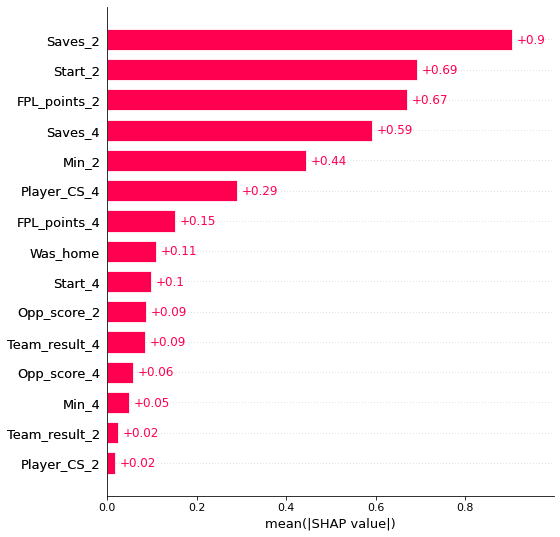

In [46]:
shap.plots.bar(shap_values, max_display=15)

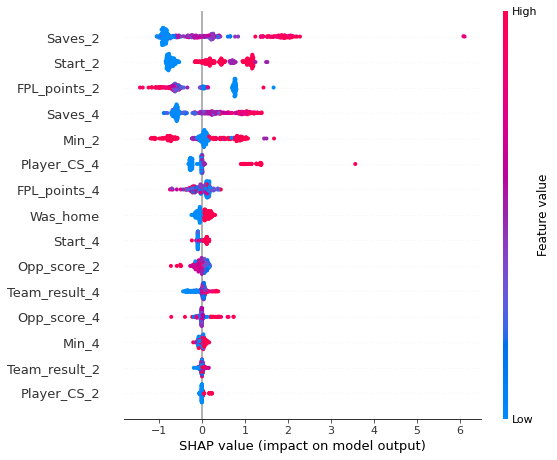

In [47]:
shap.plots.beeswarm(shap_values, max_display=15)

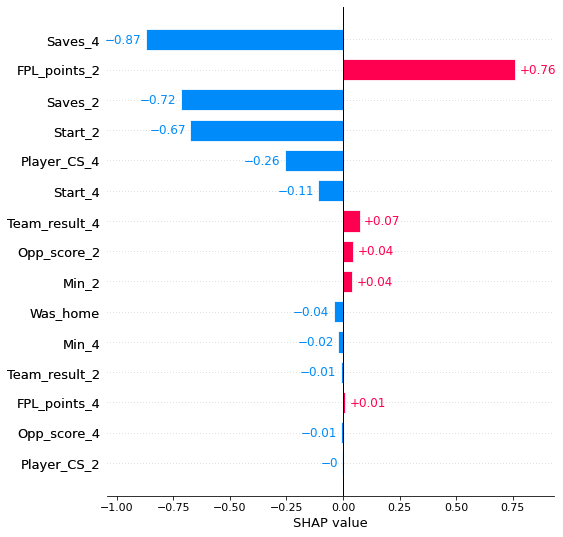

In [48]:
# explaining Erling Haaland`s score in gameweek 30
shap.plots.bar(shap_values[99], max_display=15)